In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corrcal
import hera_sim
import healpy
from astropy import constants, units
from scipy.optimize import fmin_cg
from scipy import special
%matplotlib inline

In [2]:
def square_array(N, sep=14.6):
    array = {}
    for i in range(N):
        for j in range(N):
            array[i*N+j] = np.array([i*sep, j*sep, 0])
    return array

In [3]:
# array = square_array(4)
array = hera_sim.antpos.hex_array(3, split_core=False, outriggers=0)
channel_width = 9000
integration_time = 10.7
nu0 = 150e6

In [4]:
sim = hera_sim.Simulator(
    array_layout=array,
    Nfreqs=1,
    start_freq=nu0,
    channel_width=channel_width,
    Ntimes=1,
    start_time=2458055.3,
    integration_time=10.7,
)

In [5]:
# Pull some metadata for slicing through the array
uvdata = sim.data
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [6]:
# Rather than use actual data, take a few point sources.
src_za = np.array([4 * np.pi / 5, 0 * np.pi / 3])
src_az = np.array([np.pi / 3, 5 * np.pi / 3])
src_flux = np.array([5, 5], dtype=float)
src_loc = np.array(
    [
        [np.sin(za)*np.cos(az), np.sin(za)*np.sin(az), np.cos(za)]
        for za, az in zip(src_za, src_az)
    ]
)
for i, (ai, aj) in enumerate(zip(ant_1_inds, ant_2_inds)):
    bl = antpos[aj] - antpos[ai]
    sim.data.data_array[i,...] = np.sum(
        src_flux * np.exp(
            -2j * np.pi * nu0 * src_loc @ bl / constants.c.si.value
        )
    )

In [7]:
# Get a copy of the perfectly-calibrated data
true_uvdata = uvdata.copy()

In [8]:
# Add some noise
Trx = np.min(src_flux) / 100
sim.add(
    "thermal_noise",
    Trx=Trx,
    omega_p=np.ones_like(sim.freqs)*2*np.pi,
    autovis=src_flux.sum(),
    channel_width=channel_width,
    integration_time=integration_time,
)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [9]:
uvdata.select(ant_str="cross")
true_uvdata.select(ant_str="cross")

In [10]:
groups, centers, lengths = uvdata.get_redundancies()
bls_to_keep = []
for group in groups:
    if len(group) >= 5:
        bls_to_keep += group
uvdata.select(bls=bls_to_keep)
true_uvdata.select(bls=bls_to_keep)

In [11]:
# Pull the data array and the antenna metadata again.
data = uvdata.data_array[:,0,0,0].copy()
true_data = true_uvdata.data_array[:,0,0,0].copy()
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [12]:
# Sort the data into redundant groups.
wavelength = constants.c.si.value / nu0
uvws = (antpos[ant_2_inds] - antpos[ant_1_inds]) / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvws.T[:2])
sorted_uvws = uvws[sort,:]
sorted_uvws[conj,:] *= -1
sorted_ant_1_inds = ant_1_inds[sort]
sorted_ant_2_inds = ant_2_inds[sort]
tmp = sorted_ant_1_inds.copy()
sorted_ant_1_inds[conj] = sorted_ant_2_inds[conj]
sorted_ant_2_inds[conj] = tmp[conj]
sorted_data = data[sort]
sorted_data[conj] = sorted_data[conj].conj()
sorted_true_data = true_data[sort]
sorted_true_data[conj] = sorted_true_data[conj].conj()

In [13]:
# Insert a small amount of noise for invertibility.
Jy2T = 1e-26 * wavelength**2 / (2*constants.k_B.si.value*2*np.pi)
noise_amp = (src_flux.sum() + Trx/Jy2T)**2 / (channel_width*integration_time)
noise = np.eye(data.size, dtype=complex) * noise_amp

# Mock up a covariance matrix.
n_groups = edges.size - 1
n_bls = data.size
n_src = src_flux.size
# diff_mat_amp = np.sum(src_flux)
bls = antpos[sorted_ant_2_inds] - antpos[sorted_ant_1_inds]
diff_mat = np.zeros((n_bls, n_groups), dtype=complex)
for col, (start, stop) in enumerate(zip(edges, edges[1:])):
    bl = bls[start]
    diff_mat_amp = np.sum(
        src_flux * np.exp(-2j * np.pi * nu0 * bl[None,:] @ src_loc.T / constants.c.si.value)
    )
#     diff_mat_amp = 0
    diff_mat[start:stop,col] = diff_mat_amp
diff_cov = diff_mat @ diff_mat.T.conj()
bls = antpos[sorted_ant_2_inds] - antpos[sorted_ant_1_inds]
src_mat = src_flux.reshape(1, -1) * np.exp(
    -2j * np.pi * nu0 * bls @ src_loc.T / constants.c.si.value
)
src_cov = src_mat @ src_mat.T.conj()

# Now mock up antenna gains.
n_ants = antnums.size
err = 0.05
re_gain = np.random.normal(loc=1, scale=err, size=n_ants)
im_gain = np.random.normal(loc=0, scale=err, size=n_ants)
gains = re_gain + 1j*im_gain
gain_mat = gains[sorted_ant_1_inds] * gains[sorted_ant_2_inds].conj()
gain_mat = np.diag(gain_mat)

In [47]:
np.linalg.inv(src_mat @ src_mat.T.conj() + noise)

array([[ 1.84083455-3.19744231e-14j, -0.02518357-6.32834236e-12j,
        -0.02518357+4.37404626e-12j, ..., -0.02518357-5.25185798e-13j,
        -0.02518357-6.75100947e-12j, -0.02518357-1.73371578e-11j],
       [-0.02518357+6.28123928e-12j,  1.84083455-6.01766517e-15j,
        -0.02518357+1.06048954e-11j, ..., -0.02518357+5.80060591e-12j,
        -0.02518357-4.49285168e-13j, -0.02518357-1.10795693e-11j],
       [-0.02518357-4.32052400e-12j, -0.02518357-1.06041183e-11j,
         1.84083455+2.41117086e-14j, ..., -0.02518357-4.80944417e-12j,
        -0.02518357-1.10394473e-11j, -0.02518357-2.16680745e-11j],
       ...,
       [-0.02518357+4.79304385e-13j, -0.02518357-5.80956232e-12j,
        -0.02518357+4.80379187e-12j, ...,  1.84083455-4.56516335e-14j,
        -0.02518357-6.22345957e-12j, -0.02518357-1.68828719e-11j],
       [-0.02518357+6.70803525e-12j, -0.02518357+4.41188420e-13j,
        -0.02518357+1.10359831e-11j, ..., -0.02518357+6.27392580e-12j,
         1.84083455-2.84720795e-15j

In [14]:
eigvals, eigvecs = np.linalg.eigh(diff_cov)
n = 5
eigvals = eigvals[::-1][:n]
eigvecs = eigvecs[:,::-1][:,:n]
np.allclose(diff_cov, eigvecs @ np.diag(eigvals) @ eigvecs.T.conj())

False

In [15]:
m = 6
evl, evc = np.linalg.eigh(diff_cov[edges[m]:edges[m+1],edges[m]:edges[m+1]])
evl = evl[::-1][:1]
evc = evc[:,::-1][:,:1]

In [16]:
diff_mat[edges[m],m], np.abs(diff_mat[edges[m],m])

((0.3430186516907803-1.8200342624825625j), 1.8520762705726257)

In [17]:
evc * np.sqrt(evl[None,:])

array([[1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j],
       [1.85207627+0.j]])

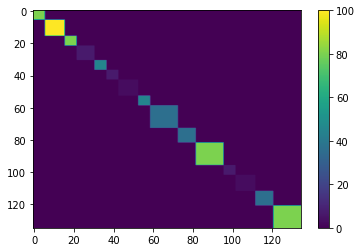

In [18]:
plt.imshow(np.abs(diff_cov), aspect='auto')
plt.colorbar()

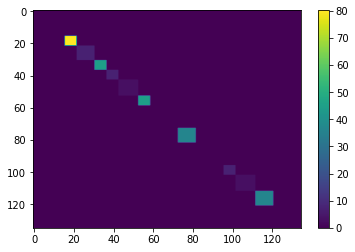

In [19]:
plt.imshow(np.abs(diff_cov - eigvecs@np.diag(eigvals)@eigvecs.T.conj()), aspect='auto')
plt.colorbar()

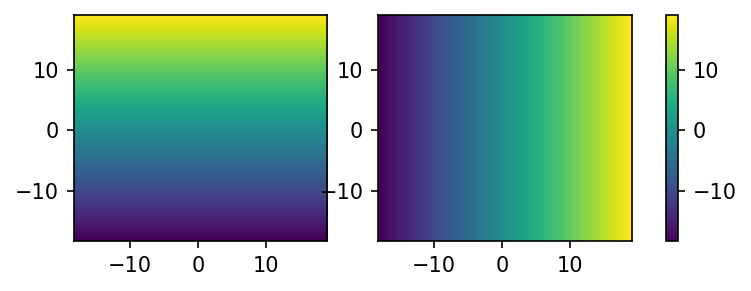

In [20]:
u_mesh = np.linspace(uvws.min(), uvws.max(), 100)
V, U = np.meshgrid(u_mesh, u_mesh, indexing="xy")
extent = (u_mesh[0], u_mesh[-1], u_mesh[0], u_mesh[-1])
fig, axes = plt.subplots(1,2,figsize=(6,2),dpi=150,facecolor='w')
cax = axes[0].imshow(U, origin='lower', aspect='auto', extent=extent)
axes[1].imshow(V, origin='lower', aspect='auto', extent=extent)
fig.colorbar(cax, ax=axes)

In [21]:
np.mean(np.diff(u_mesh))**2

0.1415106355833283

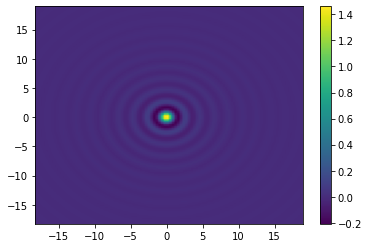

In [22]:
def jinc(x, tol=1e-8):
    return np.where(np.abs(x) < tol, np.pi/2, special.j1(np.pi*x) / x)
beam_kernel = jinc(np.sqrt(U**2 + V**2))
plt.imshow(beam_kernel, aspect='auto', origin='lower', extent=extent)
plt.colorbar()

In [23]:
phases = 2 * np.pi * (U[None,...]*src_loc[:,0][:,None,None] + V[None,...]*src_loc[:,1][:,None,None])
coeffs = np.sum(src_flux[:,None,None] * np.exp(-1j*phases), axis=0)
pspec = np.abs(coeffs) ** 2

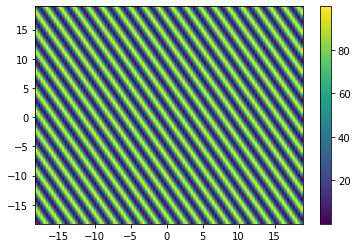

In [24]:
plt.imshow(pspec, aspect='auto', extent=extent, origin='lower')
plt.colorbar()

In [25]:
zero = np.argmin(np.abs(u_mesh))
u_shift = np.argmin(np.abs(u_mesh - sorted_uvws[edges[1]][0]))
v_shift = np.argmin(np.abs(u_mesh - sorted_uvws[edges[1]][1]))
shift = (zero - u_shift, zero - v_shift)
np.roll(U, shift, (0,1))[zero,zero], np.roll(V, shift, (0,1))[zero,zero]

(-11.115233324661833, 6.189000402791187)

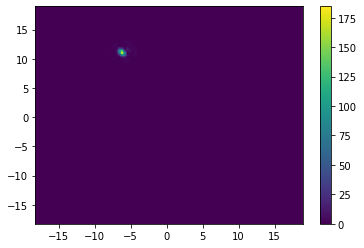

In [26]:
plt.imshow(pspec*np.abs(np.roll(beam_kernel,shift,(0,1)))**2, aspect='auto', extent=extent, origin='lower')
plt.colorbar()

In [27]:
N = 1000
kvec = np.fft.fftfreq(N, 1/(2*np.pi))
n = 4
pk = np.where(kvec != 0, 1/np.abs(kvec)**n, 0)
pk = np.sqrt(np.outer(pk,pk))

divide by zero encountered in true_divide


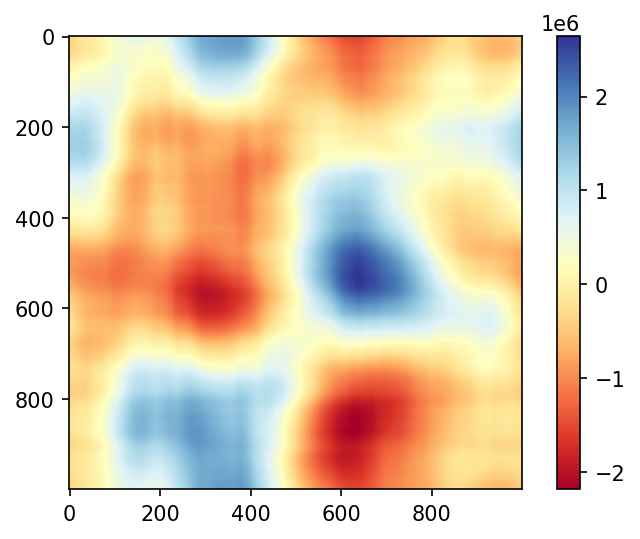

In [28]:
m = 2
kvals = np.linspace(-2,2,N)
kx, ky = np.meshgrid(kvals, kvals, indexing="xy")
kvals = np.sqrt(kx**2 + ky**2)
kcut = 0
A = 1
# pk = np.where(np.abs(kvals)>kcut, A/np.abs(kvals)**m, 0)
x = np.random.normal(size=kvals.shape)
xt = np.fft.ifft2(pk * np.fft.fft2(x))
# xt = np.fft.ifft(np.fft.fftshift(np.sqrt(pk)) *  np.fft.fft(x))
plt.figure(figsize=(6,4),dpi=150,facecolor='w')
plt.imshow(np.real(xt), cmap='RdYlBu')
plt.colorbar()

In [29]:
true_diff_cov = np.zeros_like(diff_cov)
for start, stop in zip(edges, edges[1:]):
    for left, right in zip(edges, edges[1:]):
        u, v, w = sorted_uvws[start]
        u_shift = np.argmin(np.abs(u_mesh - u))
        v_shift = np.argmin(np.abs(u_mesh - v))
        bk_A = np.roll(beam_kernel, (u_shift-zero, v_shift-zero), (0,1))
        u, v, w = sorted_uvws[left]
        u_shift = np.argmin(np.abs(u_mesh - u))
        v_shift = np.argmin(np.abs(u_mesh - v))
        bk_B = np.roll(beam_kernel, (u_shift-zero, v_shift-zero), (0,1))
        true_diff_cov[left:right,start:stop] = np.sum(pspec * bk_A * bk_B.conj())

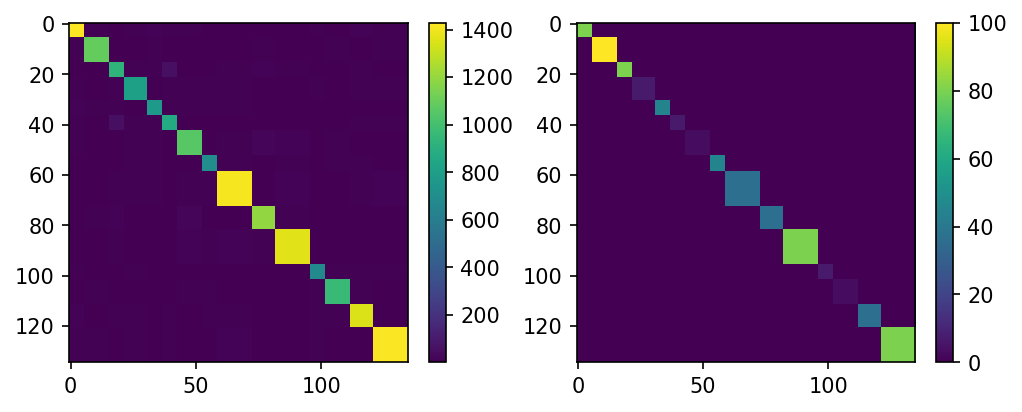

In [30]:
fig, axes = plt.subplots(1,2,figsize=(8,3),dpi=150,facecolor='w')
cax = axes[0].imshow(np.abs(true_diff_cov), aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.abs(diff_cov), aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[1])

In [31]:
diff_mat = np.zeros((n_bls, len(edges)-1), dtype=complex)
for grp, (start, stop) in enumerate(zip(edges, edges[1:])):
    block = true_diff_cov[start:stop,start:stop]
    eigvals, eigvecs = np.linalg.eigh(block)
    eigvals = eigvals[::-1][:1]
    eigvecs = eigvecs[:,::-1][:,:1]
    diff_mat[start:stop,grp:grp+1] = np.sqrt(eigvals) * eigvecs

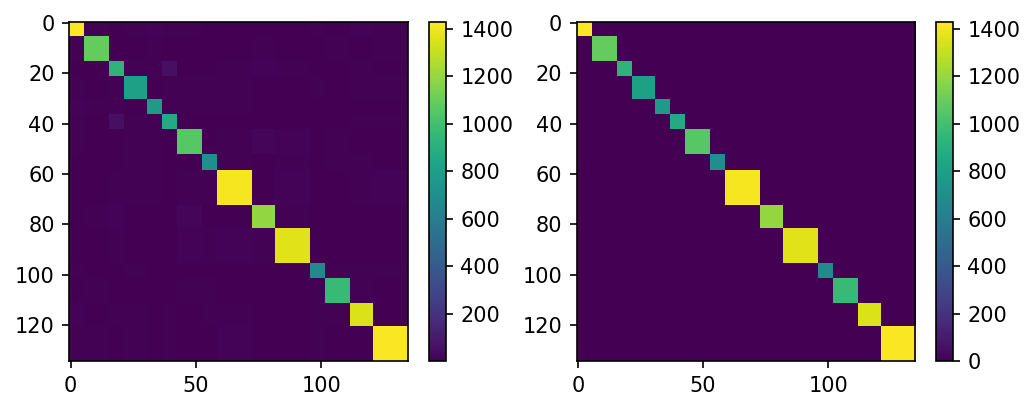

In [32]:
fig, axes = plt.subplots(1,2,figsize=(8,3),dpi=150,facecolor='w')
cax = axes[0].imshow(np.abs(true_diff_cov), aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.abs(diff_mat @ diff_mat.T.conj()), aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[1])

In [33]:
nbase = 7
nside = 2**nbase
npix = healpy.nside2npix(nside)
ipix = np.arange(npix)
pix_vecs = np.array(healpy.pix2vec(nside, ipix))
above_horizon = pix_vecs[-1] > 0
beam = np.where(above_horizon, 1, 0)
phased_beam = beam * np.exp(2j * np.pi * sorted_uvws[0] @ pix_vecs)
lmax = 3*nside - 1
blm = healpy.sphtfunc.map2alm(phased_beam, lmax=lmax, use_pixel_weights=True)
phased_beam = beam * np.exp(-2j * np.pi * sorted_uvws[edges[1]] @ pix_vecs)
blm2 = healpy.sphtfunc.map2alm(phased_beam, lmax=lmax, use_pixel_weights=True)
bl = healpy.sphtfunc.anafast(phased_beam, lmax=lmax, use_pixel_weights=True)
sky_map = np.zeros(npix)
for loc, flux in zip(src_loc, src_flux):
    sky_map[np.argmax(loc @ pix_vecs)] = flux / healpy.nside2pixarea(nside)
cl = healpy.sphtfunc.anafast(sky_map, lmax=lmax, use_pixel_weights=True)

Casting complex values to real discards the imaginary part


In [34]:
# This puts the angular power spectrum on the same "grid" as the harmonics
clm = healpy.sphtfunc.almxfl(np.ones_like(blm), cl)

In [35]:
diff_cov[0,edges[1]], true_diff_cov[0,edges[1]]

(0j, (7.429583714737302+0j))

In [36]:
2*np.sum(clm*np.real(blm*blm2.conj())) - np.sum(cl*blm[:lmax+1]*blm2[:lmax+1].conj())

(0.2283178299440113+0j)

In [37]:
sph_diff_cov = np.zeros_like(diff_cov)
for start, stop in zip(edges, edges[1:]):
    for left, right in zip(edges, edges[1:]):
        phased_beam = beam.conj() * np.exp(2j * np.pi * sorted_uvws[start] @ pix_vecs)
        blm = healpy.sphtfunc.map2alm(phased_beam, lmax=lmax, use_pixel_weights=True)
        phased_beam = beam * np.exp(-2j * np.pi * sorted_uvws[left] @ pix_vecs)
        blm2 = healpy.sphtfunc.map2alm(phased_beam, lmax=lmax, use_pixel_weights=True)
        sph_diff_cov[start:stop,left:right] = 2*np.sum(clm*np.real(blm*blm2.conj())) - np.sum(cl*blm[:lmax+1]*blm2[:lmax+1].conj())

In [38]:
b1 = beam.conj() * np.exp(2j * np.pi * sorted_uvws[edges[0]] @ pix_vecs)
blm1 = healpy.sphtfunc.map2alm(b1, lmax=lmax, use_pixel_weights=True)
b2 = beam * np.exp(-2j * np.pi * sorted_uvws[edges[5]] @ pix_vecs)
blm2 = healpy.sphtfunc.map2alm(b2, lmax=lmax, use_pixel_weights=True)

In [39]:
dat = dict(np.load("egsm_pred_50_200mhz.h5.npz"))

In [40]:
test_I = dat['imap'][50]
egsm_nside = healpy.npix2nside(test_I.size)
egsm_lmax = 3*egsm_nside - 1
assert egsm_lmax == lmax
egsm_alm = healpy.sphtfunc.map2alm(test_I, lmax=lmax, use_pixel_weights=True)
egsm_cl = healpy.sphtfunc.anafast(test_I, lmax=lmax, use_pixel_weights=True)
egsm_clm = healpy.sphtfunc.almxfl(np.ones(egsm_alm.size), egsm_cl)

In [41]:
np.sum(egsm_clm*blm1*blm1.conj())

(0.00036152735696144716-3.848848511745944e-22j)

In [42]:
np.sum(egsm_clm*blm2*blm2.conj())

(0.00036152713097965306-8.45649111272577e-22j)

In [43]:
s = 0
start = 0
for i in range(lmax):
    s += np.sum(egsm_cl[i:]*np.abs(blm1[start:start+lmax-i+1])**2)
    start += lmax - i + 1
s

0.0003615273569614474

In [44]:
2*np.sum(clm*np.real(blm1*blm1.conj())) - np.sum(cl*blm1[:lmax+1]*blm1[:lmax+1].conj())

(14.460918761204141+0j)

In [82]:
a, b = 8, 14
b1 = beam.conj() * np.exp(2j * np.pi * sorted_uvws[edges[a]] @ pix_vecs)
blm1 = healpy.sphtfunc.map2alm(b1, lmax=lmax, use_pixel_weights=True)
b2 = beam * np.exp(-2j * np.pi * sorted_uvws[edges[b]] @ pix_vecs)
blm2 = healpy.sphtfunc.map2alm(b2, lmax=lmax, use_pixel_weights=True)
bl1 = healpy.sphtfunc.alm2cl(blm1)
bl2 = healpy.sphtfunc.alm2cl(blm2)

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150,facecolor='w')
cax = axes[0].imshow(np.abs(true_diff_cov), aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.abs(diff_cov), aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[1])
cax = axes[2].imshow(np.abs(sph_diff_cov), aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[2])
fig.tight_layout()

In [ ]:
evals, evecs = np.linalg.eigh(sph_diff_cov[edges[0]:edges[1],edges[0]:edges[1]] + np.eye(edges[1]-edges[0]) * noise_amp)
np.abs(evals.max()) / np.abs(evals.min())

In [ ]:
noise_amp

**Figure ?? |** Comparison of different "diffuse matrix" calculations. *Left*: Calculation using the power spectrum and beam kernel. *Center*: Calculation using the hand-wavy "each block has the value of the visibility for that redundant group". *Right*: Calculation using the full spherical harmonic formalism. Note that while the right-most plot looks ostensibly the "most wrong", I think that this is actually the correct one. (For one, this one is calculated using the correct formalism.) The reason that each block has (very nearly) the same amplitude is sort of two-fold: first&mdash;and most important here&mdash;is that the sky only contains two point sources, and hence has roughly the same power at each $\ell$; and second, the difference between redundant groups comes down to the angular power spectra for the phased beams, which really only depend on the baseline length (since all the beams are the same, and calculating the angular power spectrum should be insensitive to rotations of the baseline's $\vec{u}$). For skies with more interesting power spectra, the "diffuse matrix" looks much more interesting.

In [ ]:
sph_diff_mat = np.zeros((n_bls, len(edges)-1), dtype=complex)
for col, (start, stop) in enumerate(zip(edges, edges[1:])):
    block = sph_diff_cov[start:stop,start:stop]
    eigvals, eigvecs = np.linalg.eigh(block)
    eigvals = eigvals[::-1][:1]
    eigvecs = eigvecs[:,::-1][:,:1]
    sph_diff_mat[start:stop,col:col+1] = np.sqrt(eigvals[None,:]) * eigvecs

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(10,5),dpi=150,facecolor='w')
cax = axes[0,0].imshow(diff_mat.real, aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[0,0], label=r"Re$\Delta_{ku}$")
cax = axes[0,1].imshow(diff_mat.imag, aspect='auto', interpolation='none', cmap='Spectral')
fig.colorbar(cax, ax=axes[0,1], label=r"Im$\Delta_{ku}$")
cax = axes[1,0].imshow(src_mat.real, aspect='auto', interpolation='none')
fig.colorbar(cax, ax=axes[1,0], label=r"Re$\sigma_{kj}$")
cax = axes[1,1].imshow(src_mat.imag, aspect='auto', interpolation='none', cmap='Spectral')
fig.colorbar(cax, ax=axes[1,1], label=r"Im$\sigma_{kj}$")

In [ ]:
noise_diag = np.diag(noise)
gain_diag = np.diag(gain_mat)
cov = corrcal.sparse.SparseCov(
    noise=noise_diag,
    gains=gain_diag,
    src_mat=src_mat,
    diff_mat=sph_diff_mat*0,
    edges=edges,
)
dense_cov = cov.expand(apply_gains=False, add_noise=False)
split_cov = corrcal.linalg.SplitMat(dense_cov)
split_noise = corrcal.linalg.SplitMat(noise)
split_data = corrcal.linalg.SplitVec(sorted_data)
init_gains = np.concatenate([re_gain, im_gain])

In [ ]:
plt.imshow(np.abs(sph_diff_cov @ sph_diff_cov.T.conj())); plt.colorbar()

In [ ]:
plt.imshow(np.abs(src_mat @ src_mat.T.conj())); plt.colorbar()

Thing to test out: point sources on the sky, set a flux limit below which sources go into the covariance as confusion noise (but are bona fide point sources in the visibilities).

In [256]:
scale = 1
dense_args = (split_data, split_noise, split_cov, sorted_ant_1_inds, sorted_ant_2_inds, "det", scale)
sparse_args = (cov, sorted_data, sorted_ant_1_inds, sorted_ant_2_inds, scale)

In [257]:
dense_fit, dense_steps = fmin_cg(
    corrcal.optimize.dense_nll,
    init_gains*scale,
    fprime=corrcal.optimize.dense_grad_nll,
    args=dense_args,
    maxiter=40,
    retall=True
)

         Current function value: -9.156510
         Iterations: 9
         Function evaluations: 76
         Gradient evaluations: 64


In [258]:
sparse_fit, sparse_steps = fmin_cg(
    corrcal.optimize.nll,
    init_gains*scale,
    fprime=corrcal.optimize.grad_nll,
    args=sparse_args,
    maxiter=40,
    retall=True,
)

Gradient isn't purely real!


         Current function value: 39.378110
         Iterations: 14
         Function evaluations: 86
         Gradient evaluations: 74


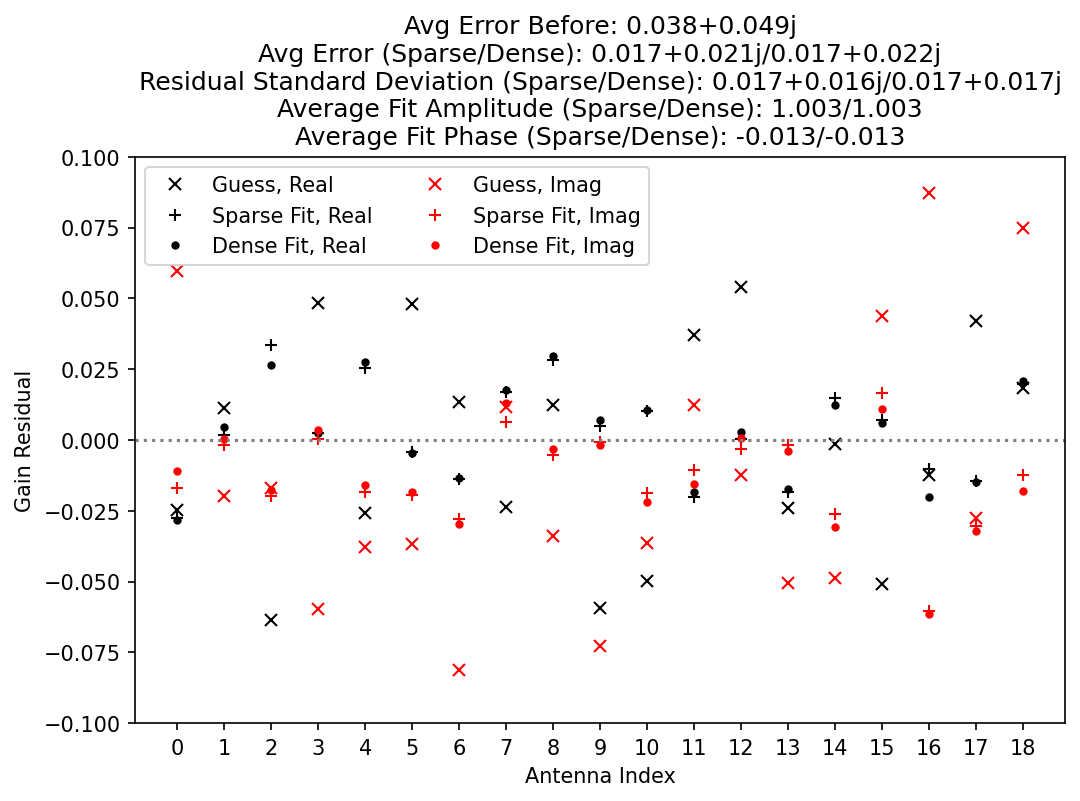

In [260]:
n_ants = gains.size
sfit = (sparse_fit[:n_ants] + 1j*sparse_fit[n_ants:]) / scale
dfit = (dense_fit[:n_ants] + 1j*dense_fit[n_ants:]) / scale
# If rephasing is desired:
# sfit *= sfit[0].conj() / np.abs(sfit[0])
# dfit *= dfit[0].conj() / np.abs(dfit[0])
def err(val, exp):
    return np.sqrt(np.mean((val - exp)**2))
avg_err_before = err(gains.real, 1) + 1j*err(gains.imag, 0)
avg_err_dense = err(dfit.real, 1) + 1j*err(dfit.imag, 0)
avg_err_sparse = err(sfit.real, 1) + 1j*err(sfit.imag, 0)
sfit_std = np.std(sfit.real) + 1j*np.std(sfit.imag)
dfit_std = np.std(dfit.real) + 1j*np.std(dfit.imag)
lim = 0.1
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
title = f"Avg Error Before: {avg_err_before:.3f}\n"
title += f"Avg Error (Sparse/Dense): {avg_err_sparse:.3f}/{avg_err_dense:.3f}\n"
title += f"Residual Standard Deviation (Sparse/Dense): {sfit_std:.3f}/{dfit_std:.3f}\n"
title += f"Average Fit Amplitude (Sparse/Dense): {np.mean(np.abs(sfit)):.3f}/{np.mean(np.abs(dfit)):.3f}\n"
title += f"Average Fit Phase (Sparse/Dense): {np.mean(np.angle(sfit)):.3f}/{np.mean(np.angle(dfit)):.3f}"
plt.title(title)
plt.plot(gains.real - 1, 'kx', label='Guess, Real')
plt.plot(sfit.real - 1, 'k+', label='Sparse Fit, Real')
plt.plot(dfit.real - 1, 'k.', label='Dense Fit, Real')
plt.plot(gains.imag, 'rx', label='Guess, Imag')
plt.plot(sfit.imag, 'r+', label='Sparse Fit, Imag')
plt.plot(dfit.imag, 'r.', label='Dense Fit, Imag')
plt.ylim(-lim,lim)
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Gain Residual")
plt.xticks(np.arange(n_ants));
# plt.savefig("example_sol_comparison_with_diffuse.png", dpi=150, bbox_inches='tight')

In [249]:
grf = healpy.sphtfunc.synfast(egsm_cl, nside, lmax=lmax)

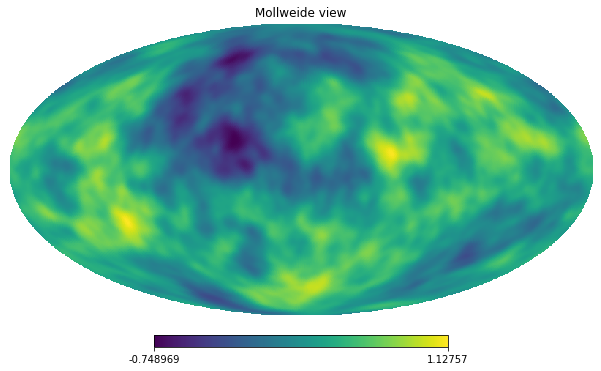

In [250]:
healpy.mollview(grf)

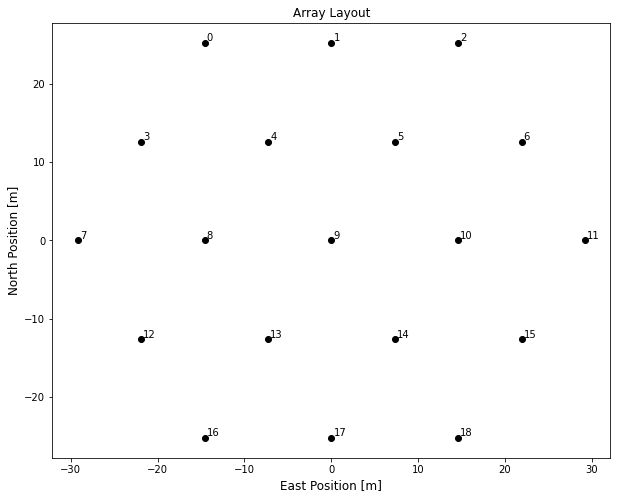

In [51]:
sim.plot_array();

In [52]:
def numerical_grad(func, param, dx, args):
    grad = np.zeros_like(param)
    shift = np.zeros_like(param)
    shift[0] = dx
    for i in range(len(param)):
        grad[i] = func(param+np.roll(shift, i), *args) - func(param-np.roll(shift, i), *args)
    return grad / (2*dx)

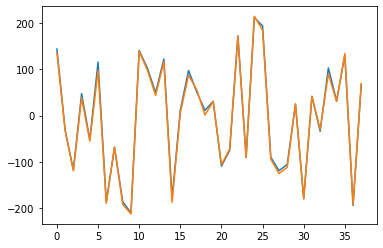

In [53]:
plt.plot(numerical_grad(corrcal.optimize.nll, init_gains*scale, 0.0001, sparse_args))
plt.plot(corrcal.optimize.grad_nll(init_gains*scale, *sparse_args)/scale)

In [54]:
corrcal.optimize.nll(corrcal.linalg.SplitVec(np.ones(n_ants,dtype=complex)).data*scale, *sparse_args)

111.38365133003973

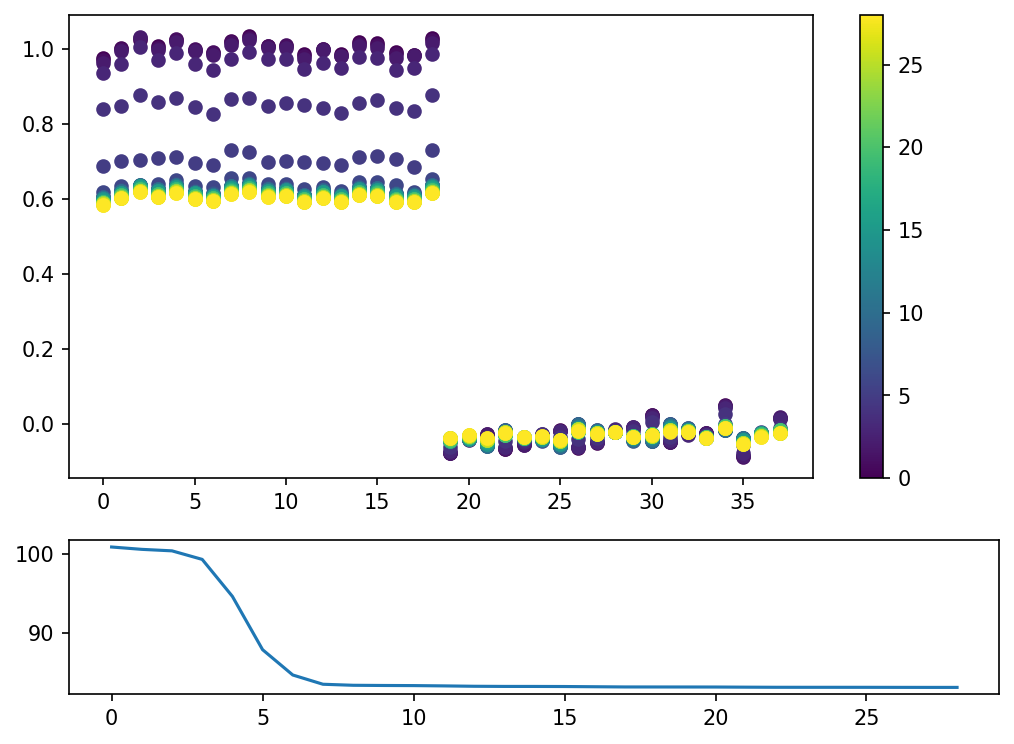

In [55]:
m = 3
n = 40
cmap = plt.cm.viridis
norm = plt.cm.colors.Normalize(vmin=0,vmax=len(sparse_steps[m:n])-1)
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
nll_values = []
fig, axes = plt.subplots(2,1,figsize=(8,6),dpi=150,facecolor='w', gridspec_kw=dict(height_ratios=[3,1]))
for i, step in enumerate(sparse_steps[m:n]):
    axes[0].plot(step/scale, lw=0, marker='o', color=cmap(norm(i)))
    nll_values.append(corrcal.optimize.nll(step, *sparse_args))
fig.colorbar(smap, ax=axes[0])
axes[1].plot(nll_values)